# Assigning the AQI values to Zip Codes and Counties

## Finding closest Station to a given zip code

In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# We load out zip code data file and make the index the zip code
zip_codes = pd.read_csv("Data/BA_ZIP_CODES.csv")
zip_codes.index = zip_codes["ZIP_CODE"]
zip_codes.head(5)

,ZIP_CODE,POPULATION_2010,HOUSING_2010,LAND_AREA_SQ_METER,LAND_AREA_SQ_MILES,LATITUDE,LONGITUDE,COUNTY
ZIP_CODE,,,,,,,,
94002,94002,25992,11108,14668197,5.663,37.514352,-122.298896,San Mateo
94005,94005,4282,1934,11384384,4.396,37.688826,-122.408935,San Mateo
94010,94010,40737,17348,30654438,11.836,37.570280,-122.365778,San Mateo
94014,94014,47014,14284,16334952,6.307,37.690868,-122.447437,San Mateo
94015,94015,60927,20678,14921282,5.761,37.681267,-122.480591,San Mateo


In [3]:
#Loading Data about Bay Area Counties

with open('Data/BA_COUNTY_DATA.json') as f:
    BA_COUNTIES  = json.load(f)

BA_COUNTIES.keys()

dict_keys(['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma'])

We then load a clean-ish data set from AQS for all California Stations (https://www.epa.gov/outdoor-air-quality-data/download-daily-data))

In [4]:
#The Data was preliminary cleaned in Excel for superflous columns and rows
cali_AQI = pd.read_csv("Data/Cali_Stations_2015_2020_ave_max.csv")
cali_AQI['Date Local'] =pd.to_datetime(cali_AQI['Date Local']).round("D")
cali_AQI.head(5)

,Parameter Code,POC,Latitude,Longitude,Parameter Name,Sample Duration,Pollutant Standard,Date Local,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI,Method Name,Local Site Name,County Name,Date of Last Change
0,88101,3,37.687526,-121.784217,PM2.5 - Local Conditions,1 HOUR,NaN,2015-01-01,Micrograms/cubic meter (LC),None,24,100,16.708333,47.0,23,NaN,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Livermore,Alameda,2/4/2016
1,88101,3,37.687526,-121.784217,PM2.5 - Local Conditions,24-HR BLK AVG,PM25 24-hour 2012,2015-01-01,Micrograms/cubic meter (LC),None,1,100,16.700000,16.7,0,61.0,-,Livermore,Alameda,2/4/2016
2,88101,3,37.743065,-122.169935,PM2.5 - Local Conditions,1 HOUR,NaN,2015-01-01,Micrograms/cubic meter (LC),None,24,100,13.458333,28.0,1,NaN,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Oakland,Alameda,2/4/2016
3,88101,3,37.743065,-122.169935,PM2.5 - Local Conditions,24-HR BLK AVG,PM25 24-hour 2012,2015-01-01,Micrograms/cubic meter (LC),None,1,100,13.400000,13.4,0,54.0,-,Oakland,Alameda,2/4/2016
4,88101,3,37.814781,-122.282347,PM2.5 - Local Conditions,1 HOUR,NaN,2015-01-01,Micrograms/cubic meter (LC),None,24,100,13.000000,35.0,21,NaN,Met One BAM-1020 Mass Monitor w/VSCC - Beta At...,Oakland West,Alameda,2/4/2016


We want to create a dictionary of all the stations in California to figure out what are the closest and second closest station to a given zip code.

In [5]:
cali_stations = cali_AQI.drop_duplicates(subset=['Local Site Name'], keep='last')[['Date Local','Local Site Name','County Name', 'Latitude','Longitude']].reset_index(drop=True)
cali_stations = cali_stations.sort_values(by='Local Site Name').reset_index(drop=True)
cali_stations.columns = ['END_DATE','NAME','COUNTY', 'LATITUDE', 'LONGITUDE']
cali_stations_f = cali_AQI.drop_duplicates(subset=['Local Site Name'])[['Date Local','Local Site Name','County Name', 'Latitude','Longitude']].sort_values(by='Local Site Name').reset_index(drop=True)
cali_stations['START_DATE'] = cali_stations_f['Date Local'].dt.strftime("%Y-%m-%d")
cali_stations['END_DATE'] = cali_stations['END_DATE'].dt.strftime("%Y-%m-%d")
cali_stations = cali_stations[['NAME','COUNTY', 'LATITUDE', 'LONGITUDE','START_DATE','END_DATE']]
cali_stations.index = cali_stations['NAME']
#cali_stations.head(5)
cali_stations

,NAME,COUNTY,LATITUDE,LONGITUDE,START_DATE,END_DATE
NAME,,,,,,
29 Palms,29 Palms,Riverside,33.719690,-116.189700,2019-03-01,2020-10-31
Anaheim,Anaheim,Orange,33.830620,-117.938450,2015-01-01,2020-06-30
Arroyo Grande CDF,Arroyo Grande CDF,San Luis Obispo,35.046730,-120.587770,2015-01-01,2020-06-30
Atascadero,Atascadero,San Luis Obispo,35.494530,-120.666170,2015-02-26,2020-06-30
Atascadero (original site),Atascadero (original site),San Luis Obispo,35.491580,-120.668040,2015-01-01,2015-02-23
...,...,...,...,...,...,...
White Mountain Research Center - Owens Valley Lab,White Mountain Research Center - Owens Valley Lab,Inyo,37.360684,-118.330783,2015-04-01,2020-06-30
Willits-125 East Commercial Street,Willits-125 East Commercial Street,Mendocino,39.411740,-123.352640,2015-01-01,2020-03-31
Woodland-Gibson Road,Woodland-Gibson Road,Yolo,38.661210,-121.732690,2015-01-06,2020-07-26


## Function definitions
Now we loop through all the zip codes and all the stations to find the nearest and second nearest station. But first we define an equation for calculating the distance bewtween two points using latitude and longitude

In [6]:
def dist_lat_long(lat1,long1,lat2,long2):
    latr1 = lat1/180*np.pi
    longr1 = long1/180*np.pi
    latr2 = lat2/180*np.pi
    longr2 = long2/180*np.pi
    # Using Haversine Formula (https://en.wikipedia.org/wiki/Haversine_formula). In km.
    dist = 2*6370*np.arcsin(np.sqrt(np.sin((latr2-latr1)/2)**2+np.cos(latr1)*np.cos(latr2)*np.sin((longr2-longr1)/2)**2))
    #Assuming a arth radius of 6370 km
    return dist

Additionally, we created a formula that calculates the Air Quality Index (AQI) based on the PM 2.5 concentration (https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf)

In [7]:
def calc_AQI(pm25):
    if pm25 < 12:
        aqi = max(round(0 + (50-0)/(12.0-0)*(pm25-0)),0)
    elif pm25 <= 35.4:
        aqi = round(51 + (100-51)/(35.4-12.1)*(pm25-12.1))
    elif pm25 <= 55.4:
        aqi = round(101 + (150-101)/(55.4-35.5)*(pm25-35.5))
    elif pm25 <= 150.4:
        aqi = round(151 + (200-151)/(150.4-55.5)*(pm25-55.5))
    elif pm25 <= 250.4:
        aqi = round(201 + (300-201)/(250.4-150.5)*(pm25-150.5))
    elif pm25 <= 350.4:
        aqi = round(301 + (400-301)/(350.4-250.5)*(pm25-250.5))
    else:
        aqi = round(401 + (500-401)/(500.4-350.5)*(pm25-350.5))
    return aqi

Finally, we assigned a level of severity with the function **level_AQI** that corresponds to:
<img src="Data/AQI_Values.jpg" alt="A Dataframe" style="width: 1000px;"/>

In [8]:
def level_AQI(aqi):
    if aqi <=50:
        level = 1
    elif aqi <=100:
        level = 2
    elif aqi <=150:
        level = 3
    elif aqi <=200:
        level = 4
    elif aqi <=300:
        level = 5
    else:
        level = 6
    return level

## Assigning AQI Stations to Zip Codes

Since there might be missing data, we are assigning a list of stations ordered by the distance to the center of the zip code

In [9]:
zip_codes['AQI_STATION_1'] = 'none'
zip_codes['AQI_D_KM_1'] = '100'
zip_codes['AQI_STATION_2'] = 'none'
zip_codes['AQI_D_KM_2'] = '100'
zip_codes['AQI_STATION_3'] = 'none'
zip_codes['AQI_D_KM_3'] = '100'
zip_codes['AQI_STATION_BA'] = 'none'
zip_codes['AQI_D_KM_BA'] = '100'
zip_codes['AQI_STATION_BA2'] = 'none'
zip_codes['AQI_D_KM_BA2'] = '100'
zip_codes['AQI_STATION_BA3'] = 'none'
zip_codes['AQI_D_KM_BA3'] = '100'
BA_counties = list(BA_COUNTIES.keys())

for zc in list(zip_codes.index):
        aq1,aq2,aq3,aqc, aqc2, aqc3 = 'none','none','none','none','none','none'
        dist1, dist2, dist3, distc, distc2, distc3 = 1000000,1000000,1000000,10000,1000,1000
        lat = zip_codes.at[zc,'LATITUDE']
        long = zip_codes.at[zc,'LONGITUDE']
        zcount = zip_codes.at[zc,'COUNTY']
        #print(zc,lat,long)
        for st in list(cali_stations.index):
            dist = dist_lat_long(lat,long,cali_stations.at[st,'LATITUDE'],cali_stations.at[st,'LONGITUDE'])
            coun = cali_stations.at[st,'COUNTY']
            #print(dist,st)
            if dist < dist1 :
                dist3 = dist2
                aq3 =aq2
                dist2 = dist1
                aq2 = aq1
                dist1 = dist.copy()
                aq1 = st
            elif dist < dist2:
                dist3 = dist2
                aq3 =aq2
                dist2 = dist.copy()
                aq2 = st
            elif dist < dist3:
                dist3 = dist
                aq3 = st
            if (dist < distc) & (coun in BA_counties):
                distc3 = distc2
                aqc3 = aqc2
                distc2 = distc
                aqc2 = aqc
                distc = dist.copy()
                aqc = st
            elif (dist < distc2) & (coun in BA_counties):
                distc3 = distc2
                aqc3 = aqc2
                distc2 = dist.copy()
                aqc2 = st
            elif (dist < distc3) & (coun in BA_counties):
                distc3 = dist
                aqc3 = st
        zip_codes.at[zc,'AQI_STATION_1'] = aq1
        zip_codes.at[zc,'AQI_STATION_2'] = aq2
        zip_codes.at[zc,'AQI_STATION_3'] = aq3
        zip_codes.at[zc,'AQI_STATION_BA'] = aqc
        zip_codes.at[zc,'AQI_STATION_BA2'] = aqc2
        zip_codes.at[zc,'AQI_STATION_BA3'] = aqc3
        zip_codes.at[zc,'AQI_D_KM_1'] = dist1
        zip_codes.at[zc,'AQI_D_KM_2'] = dist2
        zip_codes.at[zc,'AQI_D_KM_3'] = dist3
        zip_codes.at[zc,'AQI_D_KM_BA'] = distc
        zip_codes.at[zc,'AQI_D_KM_BA2'] = distc2
        zip_codes.at[zc,'AQI_D_KM_BA3'] = distc3
zip_codes

,ZIP_CODE,POPULATION_2010,HOUSING_2010,LAND_AREA_SQ_METER,LAND_AREA_SQ_MILES,LATITUDE,LONGITUDE,COUNTY,AQI_STATION_1,AQI_D_KM_1,AQI_STATION_2,AQI_D_KM_2,AQI_STATION_3,AQI_D_KM_3,AQI_STATION_BA,AQI_D_KM_BA,AQI_STATION_BA2,AQI_D_KM_BA2,AQI_STATION_BA3,AQI_D_KM_BA3
ZIP_CODE,,,,,,,,,,,,,,,,,,,,
94002,94002,25992,11108,14668197,5.663,37.514352,-122.298896,San Mateo,Redwood City,9.12116,Oakland,27.8479,San Francisco,29.3282,Redwood City,9.12116,Oakland,27.8479,San Francisco,29.3282
94005,94005,4282,1934,11384384,4.396,37.688826,-122.408935,San Mateo,San Francisco,8.61801,Laney College,17.3066,Oakland West,17.8863,San Francisco,8.61801,Laney College,17.3066,Oakland West,17.8863
94010,94010,40737,17348,30654438,11.836,37.570280,-122.365778,San Mateo,Redwood City,17.3019,San Francisco,21.9498,Oakland,25.8099,Redwood City,17.3019,San Francisco,21.9498,Oakland,25.8099
94014,94014,47014,14284,16334952,6.307,37.690868,-122.447437,San Mateo,San Francisco,9.36909,Laney College,19.8082,Oakland West,20.0096,San Francisco,9.36909,Laney College,19.8082,Oakland West,20.0096
94015,94015,60927,20678,14921282,5.761,37.681267,-122.480591,San Mateo,San Francisco,11.8345,Laney College,22.8204,Oakland West,22.8922,San Francisco,11.8345,Laney College,22.8204,Oakland West,22.8922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95625,95625,155,69,2991432,1.155,38.358121,-121.911547,Solano,Napa Valley College,32.9072,Napa,33.9514,Woodland-Gibson Road,37.1157,Napa Valley College,32.9072,Napa,33.9514,Vallejo,40.2532
95687,95687,65096,22537,112718088,43.521,38.333133,-121.920151,Solano,Napa Valley College,31.5426,Napa,32.8918,Vallejo,37.7905,Napa Valley College,31.5426,Napa,32.8918,Vallejo,37.7905
95688,95688,34379,12997,210272010,81.186,38.408571,-122.022775,Solano,Napa,26.1906,Napa Valley College,26.3019,Woodland-Gibson Road,37.7538,Napa,26.1906,Napa Valley College,26.3019,Vallejo,38.8695


From the list of stations, we can determine which are the AQI stations that feed into the Bay Area

In [10]:
BA_ind = list(pd.concat([zip_codes['AQI_STATION_1'],zip_codes['AQI_STATION_2'],zip_codes['AQI_STATION_3']]).unique())

BA_stations = cali_stations.loc[BA_ind]

BA_stations.to_csv('Data/BA_AQI_STATIONS.csv', index=False)

BA_stations = BA_stations.sort_index()

with open('Data/BA_AQI_STATIONS.json', 'w', encoding='utf-8') as f:
    json.dump(BA_stations[['NAME','COUNTY','LATITUDE','LONGITUDE']].to_dict('index'), f, ensure_ascii=False, indent=4)

BA_stations

,NAME,COUNTY,LATITUDE,LONGITUDE,START_DATE,END_DATE
NAME,,,,,,
Berkeley Aquatic Park,Berkeley Aquatic Park,Alameda,37.864767,-122.302741,2016-07-01,2020-08-31
Concord,Concord,Contra Costa,37.936013,-122.026154,2015-01-01,2020-08-31
Cortina Indian Rancheria,Cortina Indian Rancheria,Colusa,39.021221,-122.281803,2015-01-01,2020-09-15
Gilroy,Gilroy,Santa Clara,36.999571,-121.574684,2015-01-01,2020-08-31
Hollister,Hollister,San Benito,36.843425,-121.362100,2015-01-01,2020-06-30
Lakeport-Lakeport Blvd.,Lakeport-Lakeport Blvd.,Lake,39.032700,-122.922290,2015-01-06,2017-06-30
Lakeport-S. Main Street,Lakeport-S. Main Street,Lake,39.018930,-122.913330,2017-07-06,2020-06-26
Laney College,Laney College,Alameda,37.793624,-122.263376,2015-01-01,2020-08-31
Livermore,Livermore,Alameda,37.687526,-121.784217,2015-01-01,2020-08-31


Now we will clean out dataset to only include data from the stations that feed the bay area

In [11]:
indaqi = []
ir = np.array(cali_AQI['Local Site Name']=='0')
#print(list(cali_AQI['Site Name'].unique()))

for iq in list(BA_stations['NAME']):
    ib = np.array(cali_AQI['Local Site Name']==iq)
    #print(iq,np.sum(ib))
    ir = np.logical_or(ir,ib)
#print(ir)
#print('All',np.sum(ir))
## Keeping relevant stations and kepping first observation
BA_AQI = cali_AQI.loc[ir].drop_duplicates(subset=['POC', 'Date Local','Local Site Name'], keep='first')[['Local Site Name','POC','Date Local', \
                                                'Observation Count','Arithmetic Mean','1st Max Value', 'Parameter Name','Units of Measure','Method Name']]

BA_AQI.to_csv('Data/BA_AQI_DATA.csv', index=False) 
BA_AQI.head(5)


,Local Site Name,POC,Date Local,Observation Count,Arithmetic Mean,1st Max Value,Parameter Name,Units of Measure,Method Name
0,Livermore,3,2015-01-01,24,16.708333,47.0,PM2.5 - Local Conditions,Micrograms/cubic meter (LC),Met One BAM-1020 Mass Monitor w/VSCC - Beta At...
2,Oakland,3,2015-01-01,24,13.458333,28.0,PM2.5 - Local Conditions,Micrograms/cubic meter (LC),Met One BAM-1020 Mass Monitor w/VSCC - Beta At...
4,Oakland West,3,2015-01-01,24,13.000000,35.0,PM2.5 - Local Conditions,Micrograms/cubic meter (LC),Met One BAM-1020 Mass Monitor w/VSCC - Beta At...
6,Laney College,3,2015-01-01,24,10.750000,42.0,PM2.5 - Local Conditions,Micrograms/cubic meter (LC),Met One BAM-1020 Mass Monitor w/VSCC - Beta At...
11,Cortina Indian Rancheria,1,2015-01-01,24,4.708333,9.0,PM2.5 - Local Conditions,Micrograms/cubic meter (LC),Met One BAM-1020 Mass Monitor w/VSCC - Beta At...


In [12]:
# Checking for null values
BA_AQI['1st Max Value'].isnull().sum()

0

In [13]:
# Checking for null values
BA_AQI['Arithmetic Mean'].isnull().sum()

0

Now, we will create a dictionary for each relevant station that it is also a dictionary, that includes the air quality data by date

In [14]:
# Creating a Station Dictionary

station_dict = BA_stations.to_dict('index')
BA_stations['MISSING_VALUES'] = 0
date_range = list(BA_AQI['Date Local'].dt.strftime("%Y-%m-%d").unique())
n_date = len(date_range)

for st in station_dict:
    station_dict[st]['AQI'] = {}
    ind = list(BA_AQI.loc[BA_AQI['Local Site Name']==st].index)
    for dind in ind:
        ks = BA_AQI.loc[dind,'Date Local'].strftime("%Y-%m-%d")
        if ks in station_dict[st]['AQI']:
            #print('Double values for station',st,' at date ',ks)
            #print(station_dict[st]['AQI'][ks])
            station_dict[st]['AQI'][ks]['AVE_PM_2.5'] = (station_dict[st]['AQI'][ks]['AVE_PM_2.5']+ \
                BA_AQI.loc[dind,'Arithmetic Mean'])/2
            maxa =  max(list([station_dict[st]['AQI'][ks]['MAX_PM_2.5'],BA_AQI.loc[dind,'1st Max Value']]))
            station_dict[st]['AQI'][ks]['MAX_PM_2.5'] = maxa
            station_dict[st]['AQI'][ks]['24hr_AQI'] = calc_AQI(station_dict[st]['AQI'][ks]['AVE_PM_2.5'])
            station_dict[st]['AQI'][ks]['Max_AQI'] = calc_AQI(station_dict[st]['AQI'][ks]['MAX_PM_2.5'])
        else:
            station_dict[st]['AQI'][ks] = {'AVE_PM_2.5':BA_AQI.loc[dind,'Arithmetic Mean'], }
            station_dict[st]['AQI'][ks]['MAX_PM_2.5'] = BA_AQI.loc[dind,'1st Max Value']
            station_dict[st]['AQI'][ks]['24hr_AQI'] = calc_AQI(station_dict[st]['AQI'][ks]['AVE_PM_2.5'])
            station_dict[st]['AQI'][ks]['Max_AQI'] = calc_AQI(station_dict[st]['AQI'][ks]['MAX_PM_2.5'])
    BA_stations.loc[st,"MISSING_VALUES"] = n_date - len(station_dict[st]['AQI'].keys())
    
BA_stations.sort_index()

,NAME,COUNTY,LATITUDE,LONGITUDE,START_DATE,END_DATE,MISSING_VALUES
NAME,,,,,,,
Berkeley Aquatic Park,Berkeley Aquatic Park,Alameda,37.864767,-122.302741,2016-07-01,2020-08-31,640
Concord,Concord,Contra Costa,37.936013,-122.026154,2015-01-01,2020-08-31,94
Cortina Indian Rancheria,Cortina Indian Rancheria,Colusa,39.021221,-122.281803,2015-01-01,2020-09-15,305
Gilroy,Gilroy,Santa Clara,36.999571,-121.574684,2015-01-01,2020-08-31,102
Hollister,Hollister,San Benito,36.843425,-121.362100,2015-01-01,2020-06-30,106
Lakeport-Lakeport Blvd.,Lakeport-Lakeport Blvd.,Lake,39.032700,-122.922290,2015-01-06,2017-06-30,1948
Lakeport-S. Main Street,Lakeport-S. Main Street,Lake,39.018930,-122.913330,2017-07-06,2020-06-26,1923
Laney College,Laney College,Alameda,37.793624,-122.263376,2015-01-01,2020-08-31,67
Livermore,Livermore,Alameda,37.687526,-121.784217,2015-01-01,2020-08-31,76


To this dictionary we will add the newest data from AirNow (https://www.epa.gov/outdoor-air-quality-data/download-daily-data) and the BAAQMD (https://www.baaqmd.gov/about-air-quality/current-air-quality/air-monitoring-data/#/air-quality-home) that has already been compilated into one file using excel

In [15]:
cali_AQI_new = pd.read_csv("Data/BA_AQI_BAAQMD_AirNow_Newest.csv")
cali_AQI_new['Date'] =pd.to_datetime(cali_AQI_new['Date']).round("D")
cali_AQI_new.head(5)
#cali_AQI_new['Station'].sort_values().unique()

,Date,Station,Average,Maximum,Source
0,2020-03-01,San Jose - Jackson,3.6,11.0,BAAQMD
1,2020-03-01,San Jose - Knox Avenue,5.7,11.0,BAAQMD
2,2020-03-01,Redwood City,4.2,9.0,BAAQMD
3,2020-03-01,San Francisco,5.5,11.0,BAAQMD
4,2020-03-01,Sebastopol,4.7,15.0,BAAQMD


In [16]:
#CLeaning the data and removing duplicates
indaqi = []
ir = np.array(cali_AQI_new['Station']=='0')
#print(list(cali_AQI['Site Name'].unique()))

for iq in list(BA_stations['NAME']):
    ib = np.array(cali_AQI_new['Station']==iq)
    #print(iq,np.sum(ib))
    ir = np.logical_or(ir,ib)
#print(ir)
#print('All',np.sum(ir))
## Keeping relevant stations and kepping first observation
BA_AQI_new = cali_AQI_new.loc[ir].drop_duplicates(subset=['Date','Station'], keep='first').sort_values(by=['Date']).reset_index(drop=True)
BA_AQI_new.to_csv('Data/BA_AQI_DATA_2020.csv', index=False) 
BA_AQI_new.head(5)
#BA_AQI_new['Station'].unique()

,Date,Station,Average,Maximum,Source
0,2020-01-01,Ukiah-Library,5.7,5.7,AQS
1,2020-01-01,Salinas 3,10.5,10.5,AQS
2,2020-01-01,Redwood City,7.5,7.5,AQS
3,2020-01-01,Stockton-Hazelton,21.1,21.1,AQS
4,2020-01-01,San Pablo,13.0,13.0,AQS


In [17]:
date_range = list(BA_AQI_new['Date'].dt.strftime("%Y-%m-%d").unique())
date_range_all = list(pd.concat([BA_AQI['Date Local'],BA_AQI_new['Date']]).sort_values().dt.strftime("%Y-%m-%d").unique())
n_date = len(date_range_all)
for st in station_dict:
    ind = list(BA_AQI_new.loc[BA_AQI_new['Station']==st].index)
    for dind in ind:
        ks = BA_AQI_new.loc[dind,'Date'].strftime("%Y-%m-%d")
        if ks not in station_dict[st]['AQI']:
            station_dict[st]['AQI'][ks] = {}
            station_dict[st]['AQI'][ks]['AVE_PM_2.5'] = BA_AQI_new.loc[dind,'Average']
            station_dict[st]['AQI'][ks]['MAX_PM_2.5'] = BA_AQI_new.loc[dind,'Maximum']
            station_dict[st]['AQI'][ks]['24hr_AQI'] = calc_AQI(station_dict[st]['AQI'][ks]['AVE_PM_2.5'])
            station_dict[st]['AQI'][ks]['Max_AQI'] = calc_AQI(station_dict[st]['AQI'][ks]['MAX_PM_2.5'])
    BA_stations.loc[st,"MISSING_VALUES"] = n_date - len(station_dict[st]['AQI'].keys())
    BA_stations.loc[st,"END_DATE"] = max(station_dict[st]['AQI'].keys())
    
BA_stations.sort_values(by=['COUNTY'])

,NAME,COUNTY,LATITUDE,LONGITUDE,START_DATE,END_DATE,MISSING_VALUES
NAME,,,,,,,
Berkeley Aquatic Park,Berkeley Aquatic Park,Alameda,37.864767,-122.302741,2016-07-01,2020-12-31,579
Pleasanton - Owens Ct,Pleasanton - Owens Ct,Alameda,37.701222,-121.903019,2018-04-03,2020-12-31,1197
Oakland West,Oakland West,Alameda,37.814781,-122.282347,2015-01-01,2020-12-31,59
Oakland,Oakland,Alameda,37.743065,-122.169935,2015-01-01,2020-12-31,12
Livermore,Livermore,Alameda,37.687526,-121.784217,2015-01-01,2020-12-31,18
Laney College,Laney College,Alameda,37.793624,-122.263376,2015-01-01,2020-12-31,6
Cortina Indian Rancheria,Cortina Indian Rancheria,Colusa,39.021221,-122.281803,2015-01-01,2020-09-15,397
San Pablo,San Pablo,Contra Costa,37.960400,-122.356811,2015-01-01,2020-12-31,39
Concord,Concord,Contra Costa,37.936013,-122.026154,2015-01-01,2020-12-31,35


In [18]:
# Creating a CSV with the clean and mereged csv data

station = []
dicts = []

for st, d in station_dict.items():
    station.append(st)
    dicts.append(pd.DataFrame.from_dict(d['AQI'], orient='index'))

BA_AQI_all = pd.concat(dicts, keys=station)
BA_AQI_all.reset_index(inplace=True)

BA_AQI_all = BA_AQI_all.rename(columns={"level_0": "STATION", "level_1": "DATE"})
BA_AQI_all.to_csv('Data/BA_AQI_DATA_ALL.csv', index=False) 
BA_AQI_all.head(5)

,STATION,DATE,AVE_PM_2.5,MAX_PM_2.5,24hr_AQI,Max_AQI
0,Berkeley Aquatic Park,2016-07-01,17.125000,25.0,62,78
1,Berkeley Aquatic Park,2016-07-02,6.791667,14.0,28,55
2,Berkeley Aquatic Park,2016-07-03,3.666667,9.0,15,38
3,Berkeley Aquatic Park,2016-07-04,4.500000,19.0,19,66
4,Berkeley Aquatic Park,2016-07-05,5.869565,15.0,24,57


<AxesSubplot:xlabel='None-STATION', ylabel='DATE'>

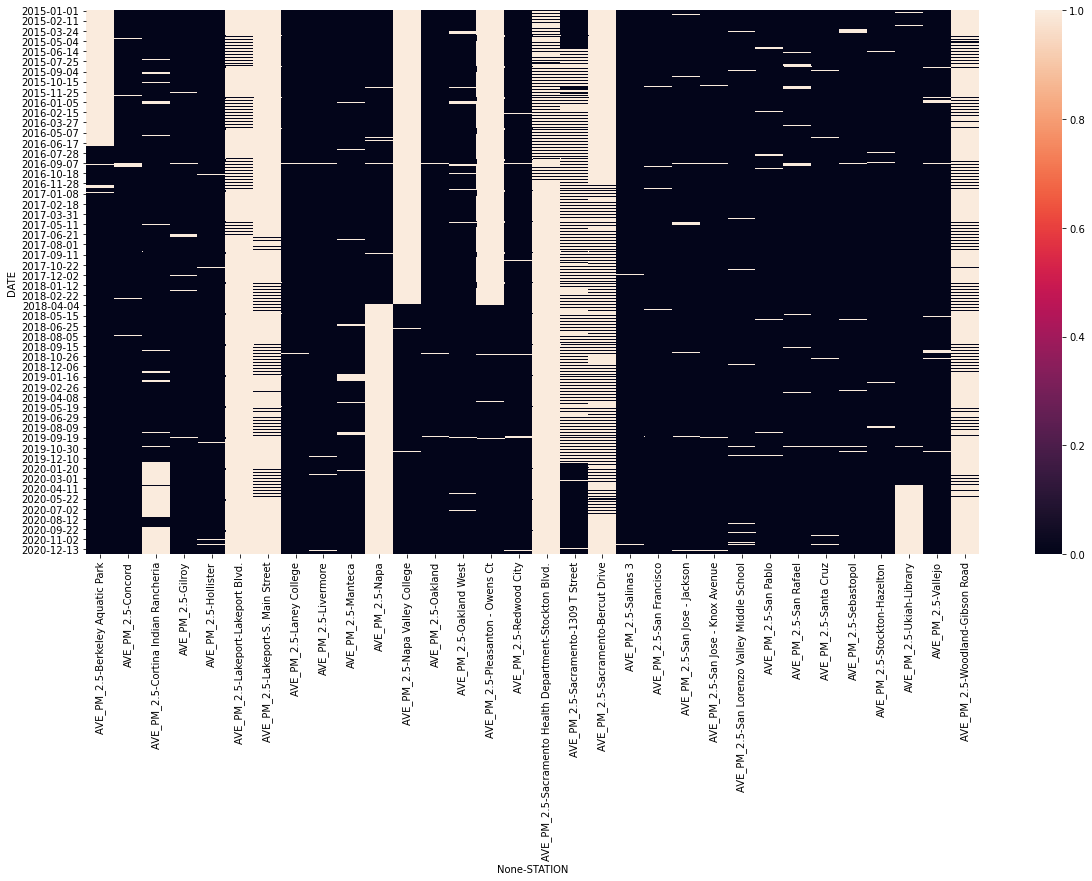

In [19]:
# Checking for Missing Values
ax = plt.figure(figsize=(20, 10))
sns.heatmap(BA_AQI_all.pivot(index='DATE', columns=['STATION'], values=['AVE_PM_2.5']).isnull())

In [20]:
with open('Data/BA_AQI_STATIONS.json', 'w', encoding='utf-8') as f:
    json.dump(station_dict, f, ensure_ascii=False, indent=4)


Now we can loop through the zip codes and assign the AQI value of the clossest station with data to the station. To deal with missing data, if none of the clossest station has a value for the date, we interpolate with the closest dates that have values.

In [21]:
zip_dict = zip_codes.to_dict('index')
date_range = list(pd.concat([BA_AQI['Date Local'],BA_AQI_new['Date']]).sort_values().dt.strftime("%Y-%m-%d").unique())
problem_zip = [];
nd = len(date_range)

for zc in zip_dict:
    zip_dict[zc]['AQI']={}
    for izd in range(nd):
        zdate = date_range[izd]
        zip_dict[zc]['AQI'][zdate] = {}
        st = []
        if zdate in station_dict[zip_dict[zc]["AQI_STATION_1"]]['AQI']:
            st = zip_dict[zc]["AQI_STATION_1"]
        elif zdate in station_dict[zip_dict[zc]["AQI_STATION_2"]]['AQI']:
            st = zip_dict[zc]["AQI_STATION_2"]
        elif zdate in station_dict[zip_dict[zc]["AQI_STATION_3"]]['AQI']:
            st = zip_dict[zc]["AQI_STATION_3"]
        elif zdate in station_dict[zip_dict[zc]["AQI_STATION_BA"]]['AQI']:
            st = zip_dict[zc]["AQI_STATION_BA"]
        if not st:
            step = 3
            zdate1 = date_range[(izd-step)]
            if (izd+step)< nd:
                zdate2 = date_range[(izd+step)]
            elif izd == nd:
                zdate2 = zdate1
            else:
                zdate2 = date_range[(nd-1)]
            
            if (zdate2 in station_dict[zip_dict[zc]["AQI_STATION_1"]]['AQI']) and (zdate1 in station_dict[zip_dict[zc]["AQI_STATION_1"]]['AQI']):
                st = zip_dict[zc]["AQI_STATION_1"]
            elif (zdate2 in station_dict[zip_dict[zc]["AQI_STATION_2"]]['AQI']) and (zdate1 in station_dict[zip_dict[zc]["AQI_STATION_2"]]['AQI']):
                st = zip_dict[zc]["AQI_STATION_2"]
            elif (zdate2 in station_dict[zip_dict[zc]["AQI_STATION_3"]]['AQI']) and (zdate1 in station_dict[zip_dict[zc]["AQI_STATION_3"]]['AQI']):
                st = zip_dict[zc]["AQI_STATION_3"]
            elif (zdate2 in station_dict[zip_dict[zc]["AQI_STATION_BA"]]['AQI']) and (zdate1 in station_dict[zip_dict[zc]["AQI_STATION_BA"]]['AQI']):
                st = zip_dict[zc]["AQI_STATION_BA"]
            elif (zdate2 in station_dict[zip_dict[zc]["AQI_STATION_BA2"]]['AQI']) and (zdate1 in station_dict[zip_dict[zc]["AQI_STATION_BA2"]]['AQI']):
                st = zip_dict[zc]["AQI_STATION_BA2"]
            else:
                st = zip_dict[zc]["AQI_STATION_BA3"]
            
            #print('interpolating for zip code and date at station',zc,zdate,st)
          
            n = 0
            zdate1 = zdate
            while zdate1 not in station_dict[st]['AQI']:
                n = n+1
                if (izd-n)> 0:
                    zdate1 = date_range[(izd-n)]
                else:
                    problem_zip.append(zc)
                    print('Weird things going on in start date for',zc,zdate)
                    break
            
            n = 0
            zdate2 = zdate
            while zdate2 not in station_dict[st]['AQI']:
                n = n+1
                if (izd+n)< nd:
                    zdate2= date_range[(izd+n)]
                else:
                    zdate2 = zdate1
                    problem_zip.append(zc)
            
            
            for kd in station_dict[st]['AQI'][zdate1].keys():
                if not isinstance(station_dict[st]['AQI'][zdate2][kd],str):
                    #print('Values for ', zc, kd, station_dict[st]['AQI'][zdate1][kd],type(station_dict[st]['AQI'][zdate2][kd]))
                    zip_dict[zc]['AQI'][zdate][kd] = round((station_dict[st]['AQI'][zdate1][kd]+
                                                           station_dict[st]['AQI'][zdate2][kd])/2)
                else:
                    zip_dict[zc]['AQI']['AQI'][zdate][kd] = station_dict[st]['AQI'][zdate1][kd].copy()    
            zip_dict[zc]['AQI'][zdate]['STATION'] = st
            if zdate1 == zdate2:
                zip_dict[zc]['AQI'][zdate]['ESTIMATED'] = True
            else:
                zip_dict[zc]['AQI'][zdate]['ESTIMATED'] = False
        else:
            zip_dict[zc]['AQI'][zdate] = station_dict[st]['AQI'][zdate].copy()
            zip_dict[zc]['AQI'][zdate]['STATION'] = st
            zip_dict[zc]['AQI'][zdate]['ESTIMATED'] = False


In [22]:
# Creating a Json File
with open('Data/BA_AQI_ZIP_CODES.json', 'w', encoding='utf-8') as f:
    json.dump(zip_dict, f, ensure_ascii=False, indent=4)

In [24]:
# Creating a CSV file

station = []
dicts = []

for st, d in zip_dict.items():
    station.append(st)
    dicts.append(pd.DataFrame.from_dict(d['AQI'], orient='index'))

BA_AQI_zc = pd.concat(dicts, keys=station)
BA_AQI_zc.reset_index(inplace=True)

BA_AQI_zc = BA_AQI_zc.rename(columns={"level_0": "Zip Code", "level_1": "DATE"})
BA_AQI_zc.head(5)

,Zip Code,DATE,AVE_PM_2.5,MAX_PM_2.5,24hr_AQI,Max_AQI,STATION,ESTIMATED
0,94002,2015-01-01,14.708333,40.0,56,112,Redwood City,False
1,94002,2015-01-02,15.500000,25.0,58,78,Redwood City,False
2,94002,2015-01-03,22.166667,33.0,72,95,Redwood City,False
3,94002,2015-01-04,24.958333,42.0,78,117,Redwood City,False
4,94002,2015-01-05,21.291667,35.0,70,99,Redwood City,False


In [25]:
BA_AQI_zc.to_csv('Data/BA_AQI_ZIP_CODES.csv', index=False) 

## AQI for Each Bay Area County
Now we can get the values for each county based on the weighted average of the zip codes based on each zipcode area

In [26]:
date_range = list(pd.concat([BA_AQI['Date Local'],BA_AQI_new['Date']]).sort_values().dt.strftime("%Y-%m-%d").unique())
nd = len(date_range)

for c in BA_COUNTIES:
    zca = list(BA_COUNTIES[c]['ZIP_CODES'])
    w_zca = []
    BA_COUNTIES[c]['AQI'] = {'AVE_PM_2.5':{},'MAX_PM_2.5':{},'24hr_AQI':{},'Max_AQI':{},'AQI_LEVEL':{},'AQI_LEVEL_MAX':{}}
    for zc in zca:
        w_zca.append(zip_dict[zc]['LAND_AREA_SQ_MILES']/BA_COUNTIES[c]['LAND_AREA_SQ_MILES'])
    for ks in date_range:
        aveq,maxq = 0,0
        for zc in range(len(zca)):
            aveq = aveq + w_zca[zc]*zip_dict[zca[zc]]['AQI'][ks]['AVE_PM_2.5']
            maxq = max([maxq,zip_dict[zca[zc]]['AQI'][ks]['MAX_PM_2.5']])
        BA_COUNTIES[c]['AQI']['AVE_PM_2.5'][ks] = aveq
        BA_COUNTIES[c]['AQI']['MAX_PM_2.5'][ks] = maxq
        BA_COUNTIES[c]['AQI']['24hr_AQI'][ks] = calc_AQI(aveq)
        BA_COUNTIES[c]['AQI']['Max_AQI'][ks] = calc_AQI(maxq)
        BA_COUNTIES[c]['AQI']['AQI_LEVEL'][ks] = level_AQI(BA_COUNTIES[c]['AQI']['24hr_AQI'][ks])
        BA_COUNTIES[c]['AQI']['AQI_LEVEL_MAX'][ks] = level_AQI(BA_COUNTIES[c]['AQI']['Max_AQI'][ks])


In [27]:
with open('Data/BA_AQI_COUNTIES.json', 'w', encoding='utf-8') as f:
    json.dump(BA_COUNTIES, f, ensure_ascii=False, indent=4)

In [28]:
#Changing to a data frame to create csv file

counties = []
dicts = []

for c, d in BA_COUNTIES.items():
    counties.append(c)
    dicts.append(pd.DataFrame.from_dict(d['AQI'], orient='index'))

BAC_AQI_all = pd.concat(dicts, keys=counties).transpose()
BAC_AQI_all = BAC_AQI_all.stack(level=0).reset_index().rename(columns={"level_0": "DATE",'level_1':'COUNTY'})
BAC_AQI_all.head(5)

,DATE,COUNTY,24hr_AQI,AQI_LEVEL,AQI_LEVEL_MAX,AVE_PM_2.5,MAX_PM_2.5,Max_AQI
0,2015-01-01,Alameda,68.0,2.0,3.0,19.962676,52.0,142.0
1,2015-01-01,Contra Costa,71.0,2.0,4.0,21.403465,66.0,156.0
2,2015-01-01,Marin,82.0,2.0,3.0,26.721842,55.0,149.0
3,2015-01-01,Napa,88.0,2.0,4.0,29.813729,76.0,162.0
4,2015-01-01,San Francisco,54.0,2.0,2.0,13.625703,32.0,93.0


In [29]:
BAC_AQI_all.to_csv('Data/BA_AQI_COUNTIES.csv', index=False) 

## AQI for Bay Area as a Whole

We will average by both area and population.

In [30]:
date_range = list(pd.concat([BA_AQI['Date Local'],BA_AQI_new['Date']]).sort_values().dt.strftime("%Y-%m-%d").unique())
nd = len(date_range)
BA_area = 0
BA_pop = 0
w_zca = []
w_zcp = []
zca = list(zip_dict.keys())

for zc in zip_dict:
    BA_area = BA_area + zip_dict[zc]['LAND_AREA_SQ_MILES']
    BA_pop = BA_pop +  zip_dict[zc]['POPULATION_2010']
BA = {}
for zc in zip_dict:
        w_zca.append(zip_dict[zc]['LAND_AREA_SQ_MILES']/BA_area)
        w_zcp.append(zip_dict[zc]['POPULATION_2010']/BA_pop)
for ks in date_range:
        BA[ks] = {}
        aveqa,maxq,aveqp = 0,0,0
        ag, amod, auhsg, auh, avuh,ah =0,0,0,0,0,0
        pg, pmod, puhsg, puh, pvuh,ph =0,0,0,0,0,0
        mag, mamod, mauhsg, mauh, mavuh,mah =0,0,0,0,0,0
        mpg, mpmod, mpuhsg, mpuh, mpvuh,mph =0,0,0,0,0,0
        for zc in range(len(zca)):
            aaqi =zip_dict[zca[zc]]['AQI'][ks]['AVE_PM_2.5']
            maqi =zip_dict[zca[zc]]['AQI'][ks]['MAX_PM_2.5']
            aveqa = aveqa + w_zca[zc]*aaqi
            maxq = max([maxq,maqi])
            aveqp = aveqp + w_zcp[zc]*aaqi
            leva = level_AQI(calc_AQI(aaqi))
            levm = level_AQI(calc_AQI(maqi))
            if leva <=1:
                ag = ag + w_zca[zc]
                pg = pg + w_zcp[zc]
            elif leva <=2:
                amod = amod + w_zca[zc]
                pmod = pmod + w_zcp[zc]
            elif leva <=3:
                auhsg = auhsg + w_zca[zc]
                puhsg = puhsg + w_zcp[zc]
            elif leva <=4:
                auh = auh + w_zca[zc]
                puh = puh + w_zcp[zc]
            elif leva <=5:
                avuh = avuh + w_zca[zc]
                pvuh = pvuh + w_zcp[zc]
            else:
                ah = ah + w_zca[zc]
                ph = ph + w_zcp[zc]
            if levm <=1:
                mag = mag + w_zca[zc]
                mpg = mpg + w_zcp[zc]
            elif levm <=2:
                mamod = mamod + w_zca[zc]
                mpmod = mpmod + w_zcp[zc]
            elif levm <=3:
                mauhsg = mauhsg + w_zca[zc]
                mpuhsg = mpuhsg + w_zcp[zc]
            elif levm <=4:
                mauh = mauh + w_zca[zc]
                mpuh = mpuh + w_zcp[zc]
            elif levm <=5:
                mavuh = mavuh + w_zca[zc]
                mpvuh = mpvuh + w_zcp[zc]
            else:
                mah = mah + w_zca[zc]
                mph = mph + w_zcp[zc]
        # Writing totals
        BA[ks]['AREA_AVE_PM_2.5'] = aveqa
        BA[ks]['AREA_24hr_AQI'] = calc_AQI(aveqa)
        BA[ks]['AREA_AQI_LEVEL'] = level_AQI(BA[ks]['AREA_24hr_AQI'])
        BA[ks]['AREA_GOOD'] =ag
        BA[ks]['AREA_MOD'] =amod
        BA[ks]['AREA_UHSG'] =auhsg
        BA[ks]['AREA_UH'] =auh
        BA[ks]['AREA_VUH'] =avuh
        BA[ks]['AREA_HAZ'] =ah
        BA[ks]['AREA_GOOD_MAX'] =mag
        BA[ks]['AREA_MOD_MAX'] =mamod
        BA[ks]['AREA_UHSG_MAX'] =mauhsg
        BA[ks]['AREA_UH_MAX'] =mauh
        BA[ks]['AREA_VUH_MAX'] =mavuh
        BA[ks]['AREA_HAZ_MAX'] =mah
        BA[ks]['POP_AVE_PM_2.5'] = aveqp
        BA[ks]['POP_24hr_AQI'] = calc_AQI(aveqp)
        BA[ks]['POP_AQI_LEVEL'] = level_AQI(BA[ks]['POP_24hr_AQI'])
        BA[ks]['POP_GOOD'] =pg
        BA[ks]['POP_MOD'] =pmod
        BA[ks]['POP_UHSG'] =puhsg
        BA[ks]['POP_UH'] =puh
        BA[ks]['POP_VUH'] =pvuh
        BA[ks]['POP_HAZ'] =ph
        BA[ks]['POP_GOOD_MAX'] =mpg
        BA[ks]['POP_MOD_MAX'] =mpmod
        BA[ks]['POP_UHSG_MAX'] =mpuhsg
        BA[ks]['POP_UH_MAX'] =mpuh
        BA[ks]['POP_VUH_MAX'] =mpvuh
        BA[ks]['POP_HAZ_MAX'] =mph
        BA[ks]['MAX_PM_2.5'] = maxq
        BA[ks]['Max_AQI'] = calc_AQI(maxq)
        BA[ks]['AQI_LEVEL_MAX'] = level_AQI(BA[ks]['Max_AQI'] )

In [31]:
BA_table = pd.DataFrame.from_dict(BA,orient='index')
BA_table.head(10)

,AREA_AVE_PM_2.5,AREA_24hr_AQI,AREA_AQI_LEVEL,AREA_GOOD,AREA_MOD,AREA_UHSG,AREA_UH,AREA_VUH,AREA_HAZ,AREA_GOOD_MAX,...,POP_HAZ,POP_GOOD_MAX,POP_MOD_MAX,POP_UHSG_MAX,POP_UH_MAX,POP_VUH_MAX,POP_HAZ_MAX,MAX_PM_2.5,Max_AQI,AQI_LEVEL_MAX
2015-01-01,21.572190,71,2,0.075346,0.924654,0.000000,0.000000,0.0,0.0,0.071026,...,0.0,0.006689,0.260327,0.636003,0.096981,0.0,0.0,76.0,162,4
2015-01-02,23.234700,74,2,0.053861,0.902882,0.043257,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.674547,0.285063,0.040390,0.0,0.0,67.0,157,4
2015-01-03,25.692225,80,2,0.053861,0.903650,0.042489,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.210978,0.658590,0.130432,0.0,0.0,75.0,161,4
2015-01-04,26.071521,80,2,0.053861,0.946139,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.061115,0.891222,0.047664,0.0,0.0,71.0,159,4
2015-01-05,23.524081,75,2,0.071026,0.913337,0.015636,0.000000,0.0,0.0,0.017165,...,0.0,0.000084,0.496866,0.497170,0.005880,0.0,0.0,66.0,156,4
2015-01-06,21.109008,70,2,0.111207,0.882551,0.006242,0.000000,0.0,0.0,0.040181,...,0.0,0.001738,0.280627,0.717634,0.000000,0.0,0.0,55.0,149,3
2015-01-07,18.079864,64,2,0.183736,0.800628,0.015636,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.624852,0.370745,0.004402,0.0,0.0,64.0,155,4
2015-01-08,22.841598,74,2,0.143564,0.803385,0.053051,0.000000,0.0,0.0,0.053861,...,0.0,0.006605,0.035344,0.737410,0.220642,0.0,0.0,71.0,159,4
2015-01-09,19.947318,68,2,0.143564,0.840800,0.000000,0.015636,0.0,0.0,0.053861,...,0.0,0.006605,0.304050,0.684943,0.004402,0.0,0.0,77.0,162,4
2015-01-10,19.186738,66,2,0.071026,0.870081,0.058893,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.847920,0.147678,0.004402,0.0,0.0,67.0,157,4


In [32]:
BA_table['DATE'] = BA_table.index
BA_table.to_csv('Data/BA_AQI_SUMMARY.csv', index=False)

In [33]:
BA_table.tail(10)

,AREA_AVE_PM_2.5,AREA_24hr_AQI,AREA_AQI_LEVEL,AREA_GOOD,AREA_MOD,AREA_UHSG,AREA_UH,AREA_VUH,AREA_HAZ,AREA_GOOD_MAX,...,POP_GOOD_MAX,POP_MOD_MAX,POP_UHSG_MAX,POP_UH_MAX,POP_VUH_MAX,POP_HAZ_MAX,MAX_PM_2.5,Max_AQI,AQI_LEVEL_MAX,DATE
2020-12-22,9.007351,38,1,0.728478,0.271522,0.000000,0.0,0.0,0.0,0.161234,...,0.221917,0.736141,0.041942,0.000000,0.0,0.0,41.0,115,3,2020-12-22
2020-12-23,10.044899,42,1,0.875494,0.124506,0.000000,0.0,0.0,0.0,0.053861,...,0.006605,0.993395,0.000000,0.000000,0.0,0.0,30.0,89,2,2020-12-23
2020-12-24,19.803834,67,2,0.053861,0.938711,0.007428,0.0,0.0,0.0,0.053861,...,0.006605,0.428991,0.482301,0.082104,0.0,0.0,66.0,156,4,2020-12-24
2020-12-25,15.302203,58,2,0.258951,0.741049,0.000000,0.0,0.0,0.0,0.053861,...,0.006605,0.484291,0.509104,0.000000,0.0,0.0,54.0,147,3,2020-12-25
2020-12-26,6.248538,26,1,0.957511,0.042489,0.000000,0.0,0.0,0.0,0.164063,...,0.062592,0.909534,0.027874,0.000000,0.0,0.0,45.0,124,3,2020-12-26
2020-12-27,6.400250,27,1,0.984364,0.015636,0.000000,0.0,0.0,0.0,0.456887,...,0.469991,0.530009,0.000000,0.000000,0.0,0.0,35.0,99,2,2020-12-27
2020-12-28,7.009442,29,1,0.984364,0.015636,0.000000,0.0,0.0,0.0,0.118623,...,0.014719,0.957052,0.028229,0.000000,0.0,0.0,49.0,134,3,2020-12-28
2020-12-29,8.690918,36,1,0.913402,0.086598,0.000000,0.0,0.0,0.0,0.118623,...,0.014719,0.985281,0.000000,0.000000,0.0,0.0,34.0,97,2,2020-12-29
2020-12-30,8.074359,34,1,0.824461,0.175539,0.000000,0.0,0.0,0.0,0.132889,...,0.188529,0.811471,0.000000,0.000000,0.0,0.0,32.0,93,2,2020-12-30
2020-12-31,10.463337,44,1,0.743188,0.256812,0.000000,0.0,0.0,0.0,0.118623,...,0.014719,0.346635,0.379073,0.259573,0.0,0.0,87.0,167,4,2020-12-31
